<a href="https://colab.research.google.com/github/Tharun3111/Bi-Pedal_walker/blob/main/BI_pedal_walker_(DDPG_%26_TD3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym

In [ ]:
pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 11.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

In [ ]:
import numpy as np


class Buffer:
    def __init__(self, observationDim: int, actionDim: int, size: int = 1_000_000):
        # use a fixed-size buffer to prevent constant list instantiations
        self.states = np.zeros((size, observationDim))
        self.actions = np.zeros((size, actionDim))
        self.rewards = np.zeros(size)
        self.nextStates = np.zeros((size, observationDim))
        self.doneFlags = np.zeros(size)
        # use a pointer to keep track of where in the buffer we are
        self.pointer = 0
        # use current size to ensure we don't train on any non-existent data points
        self.currentSize = 0
        self.size = size

    def store(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        nextState: np.ndarray,
        doneFlag: bool,
    ):
        # store all the data for this transition
        ptr = self.pointer
        self.states[ptr] = state
        self.actions[ptr] = action
        self.rewards[ptr] = reward
        self.nextStates[ptr] = nextState
        self.doneFlags[ptr] = doneFlag
        # update the pointer and current size
        self.pointer = (self.pointer + 1) % self.size
        self.currentSize = min(self.currentSize + 1, self.size)

    def getMiniBatch(self, size: int) -> dict:
        # ensure size is not bigger than the current size of the buffer
        size = min(size, self.currentSize)
        # generate random indices
        indices = np.random.choice(self.currentSize, size, replace=False)
        # return the mini-batch of transitions
        return {
            "states": self.states[indices],
            "actions": self.actions[indices],
            "rewards": self.rewards[indices],
            "nextStates": self.nextStates[indices],
            "doneFlags": self.doneFlags[indices],
        }

In [ ]:
from typing import Callable
import torch as T
import torch.nn as nn
import torch.optim as optim


class Network(nn.Module):
    def __init__(
        self,
        shape: list,
        outputActivation: Callable,
        learningRate: float,
        device: T.device,
    ):
        super().__init__()
        # initialize the network
        layers = []
        for i in range(1, len(shape)):
            dim1 = shape[i - 1]
            dim2 = shape[i]
            layers.append(nn.Linear(dim1, dim2))
            if i < len(shape) - 1:
                layers.append(nn.ReLU())
        layers.append(outputActivation())
        self.network = nn.Sequential(*layers)

        self.optimizer = optim.Adam(self.parameters(), lr=learningRate)
        self.device = device
        self.to(self.device)

    def forward(self, state: object) -> object:
        return self.network(state)

    def gradientDescentStep(self, loss: T.Tensor, retainGraph: bool = False):
        self.optimizer.zero_grad()
        loss.backward(retain_graph=retainGraph)
        self.optimizer.step()

In [ ]:
import numpy as np
import os
import pickle
import torch as T
import torch.nn as nn
from copy import deepcopy
from gym.core import Env
# from Buffer import Buffer
# from Network import Network


class Agent:
    def __init__(
        self,
        env: Env,
        learningRate: float,
        gamma: float,
        tau: float,
        shouldLoad: bool = True,
        saveFolder: str = "saved",
    ):
        self.observationDim = env.observation_space.shape[0]
        self.actionDim = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau
        # check if the saveFolder path exists
        if not os.path.isdir(saveFolder):
            os.mkdir(saveFolder)
        self.envName = os.path.join(saveFolder, env.name + ".")
        name = self.envName
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.buffer = (
            pickle.load(open(name + "Replay", "rb"))
            if shouldLoad and os.path.exists(name + "Replay")
            else Buffer(self.observationDim, self.actionDim)
        )
        # initialize the actor and critics
        self.actor = (
            pickle.load(open(name + "Actor", "rb"))
            if shouldLoad and os.path.exists(name + "Actor")
            else Network(
                [self.observationDim, 256, 256, self.actionDim],
                nn.Tanh,
                learningRate,
                self.device,
            )
        )
        self.critic1 = (
            pickle.load(open(name + "Critic1", "rb"))
            if shouldLoad and os.path.exists(name + "Critic1")
            else Network(
                [self.observationDim + self.actionDim, 256, 256, 1],
                nn.Identity,
                learningRate,
                self.device,
            )
        )
        self.critic2 = (
            pickle.load(open(name + "Critic2", "rb"))
            if shouldLoad and os.path.exists(name + "Critic2")
            else Network(
                [self.observationDim + self.actionDim, 256, 256, 1],
                nn.Identity,
                learningRate,
                self.device,
            )
        )
        # create target networks
        self.targetActor = (
            pickle.load(open(name + "TargetActor", "rb"))
            if shouldLoad and os.path.exists(name + "TargetActor")
            else deepcopy(self.actor)
        )
        self.targetCritic1 = (
            pickle.load(open(name + "TargetCritic1", "rb"))
            if shouldLoad and os.path.exists(name + "TargetCritic1")
            else deepcopy(self.critic1)
        )
        self.targetCritic2 = (
            pickle.load(open(name + "TargetCritic2", "rb"))
            if shouldLoad and os.path.exists(name + "TargetCritic2")
            else deepcopy(self.critic2)
        )

    def getNoisyAction(self, state: np.ndarray, sigma: float) -> np.ndarray:
        deterministicAction = self.getDeterministicAction(state)
        noise = np.random.normal(0, sigma, deterministicAction.shape)
        return np.clip(deterministicAction + noise, -1, +1)

    def getDeterministicAction(self, state: np.ndarray) -> np.ndarray:
        actions: T.Tensor = self.actor.forward(T.tensor(state, device=self.device))
        return actions.cpu().detach().numpy()

    def update(
        self,
        miniBatchSize: int,
        trainingSigma: float,
        trainingClip: float,
        updatePolicy: bool,
    ):
        # randomly sample a mini-batch from the replay buffer
        miniBatch = self.buffer.getMiniBatch(miniBatchSize)
        # create tensors to start generating computational graph
        states = T.tensor(miniBatch["states"], requires_grad=True, device=self.device)
        actions = T.tensor(miniBatch["actions"], requires_grad=True, device=self.device)
        rewards = T.tensor(miniBatch["rewards"], requires_grad=True, device=self.device)
        nextStates = T.tensor(
            miniBatch["nextStates"], requires_grad=True, device=self.device
        )
        dones = T.tensor(miniBatch["doneFlags"], requires_grad=True, device=self.device)
        # compute the targets
        targets = self.computeTargets(
            rewards, nextStates, dones, trainingSigma, trainingClip
        )
        # do a single step on each critic network
        Q1Loss = self.computeQLoss(self.critic1, states, actions, targets)
        self.critic1.gradientDescentStep(Q1Loss, True)
        Q2Loss = self.computeQLoss(self.critic2, states, actions, targets)
        self.critic2.gradientDescentStep(Q2Loss)
        if updatePolicy:
            # do a single step on the actor network
            policyLoss = self.computePolicyLoss(states)
            self.actor.gradientDescentStep(policyLoss)
            # update target networks
            self.updateTargetNetwork(self.targetActor, self.actor)
            self.updateTargetNetwork(self.targetCritic1, self.critic1)
            self.updateTargetNetwork(self.targetCritic2, self.critic2)

    def computeTargets(
        self,
        rewards: T.Tensor,
        nextStates: T.Tensor,
        dones: T.Tensor,
        trainingSigma: float,
        trainingClip: float,
    ) -> T.Tensor:
        targetActions = self.targetActor.forward(nextStates.float())
        # create additive noise for target actions
        noise = np.random.normal(0, trainingSigma, targetActions.shape)
        clippedNoise = T.tensor(
            np.clip(noise, -trainingClip, +trainingClip), device=self.device
        )
        targetActions = T.clip(targetActions + clippedNoise, -1, +1)
        # compute targets
        targetQ1Values = T.squeeze(
            self.targetCritic1.forward(T.hstack([nextStates, targetActions]).float())
        )
        targetQ2Values = T.squeeze(
            self.targetCritic2.forward(T.hstack([nextStates, targetActions]).float())
        )
        targetQValues = T.minimum(targetQ1Values, targetQ2Values)
        return rewards + self.gamma * (1 - dones) * targetQValues

    def computeQLoss(
        self, network: Network, states: T.Tensor, actions: T.Tensor, targets: T.Tensor
    ) -> T.Tensor:
        # compute the MSE of the Q function with respect to the targets
        QValues = T.squeeze(network.forward(T.hstack([states, actions]).float()))
        return T.square(QValues - targets).mean()

    def computePolicyLoss(self, states: T.Tensor):
        actions = self.actor.forward(states.float())
        QValues = T.squeeze(self.critic1.forward(T.hstack([states, actions]).float()))
        return -QValues.mean()

    def updateTargetNetwork(self, targetNetwork: Network, network: Network):
        with T.no_grad():
            for targetParameter, parameter in zip(
                targetNetwork.parameters(), network.parameters()
            ):
                targetParameter.mul_(1 - self.tau)
                targetParameter.add_(self.tau * parameter)

    def save(self):
        name = self.envName
        pickle.dump(self.buffer, open(name + "Replay", "wb"))
        pickle.dump(self.actor, open(name + "Actor", "wb"))
        pickle.dump(self.critic1, open(name + "Critic1", "wb"))
        pickle.dump(self.critic2, open(name + "Critic2", "wb"))
        pickle.dump(self.targetActor, open(name + "TargetActor", "wb"))
        pickle.dump(self.targetCritic1, open(name + "TargetCritic1", "wb"))
        pickle.dump(self.targetCritic2, open(name + "TargetCritic2", "wb"))

In [ ]:
import csv
import gym
# from Agent import Agent
from os import path

# HYPERPARAMETERS BELOW
gamma = 0.99  # discount factor for rewards
learningRate = 3e-4  # learning rate for actor and critic networks
tau = 0.005  # tracking parameter used to update target networks slowly
actionSigma = 0.1  # contributes noise to deterministic policy output
trainingSigma = 0.2  # contributes noise to target actions
trainingClip = 0.5  # clips target actions to keep them close to true actions
miniBatchSize = 100  # how large a mini-batch should be when updating
policyDelay = 2  # how many steps to wait before updating the policy
resume = True  # resume from previous checkpoint if possible?
render = False  # render out the environment on-screen?

envName = "BipedalWalker-v3"

for trial in range(64):
    env = gym.make(envName)
    env.name = envName + "_" + str(trial)
    csvName = env.name + "-data.csv"
    agent = Agent(env, learningRate, gamma, tau, resume)
    state = env.reset()
    step = 0
    runningReward = None

    # determine the last episode if we have saved training in progress
    numEpisode = 0
    if path.exists(csvName):
        fileData = list(csv.reader(open(csvName)))
        lastLine = fileData[-1]
        numEpisode = int(lastLine[0])

    while numEpisode <= 1000:
        # choose an action from the agent's policy
        action = agent.getNoisyAction(state, actionSigma)
        # take a step in the environment and collect information
        nextState, reward, done, info = env.step(action)
        # store data in buffer
        agent.buffer.store(state, action, reward, nextState, done)

        if done:
            numEpisode += 1
            # evaluate the deterministic agent on a test episode
            sumRewards = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.getDeterministicAction(state)
                nextState, reward, done, info = env.step(action)
                if render:
                    env.render()
                state = nextState
                sumRewards += reward
            state = env.reset()
            # keep a running average to see how well we're doing
            runningReward = (
                sumRewards
                if runningReward is None
                else runningReward * 0.99 + sumRewards * 0.01
            )
            # log progress in csv file
            fields = [numEpisode, sumRewards, runningReward]
            with open(env.name + "-data.csv", "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow(fields)
            agent.save()
            # print episode tracking
            print(
                f"episode {numEpisode:6d} --- "
                + f"total reward: {sumRewards:7.2f} --- "
                + f"running average: {runningReward:7.2f}",
                flush=True,
            )
        else:
            state = nextState
        step += 1

        shouldUpdatePolicy = step % policyDelay == 0
        agent.update(miniBatchSize, trainingSigma, trainingClip, shouldUpdatePolicy)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode      1 --- total reward: -104.30 --- running average: -104.30
episode      2 --- total reward: -126.15 --- running average: -104.52
episode      3 --- total reward: -181.48 --- running average: -105.29
episode      4 --- total reward: -100.82 --- running average: -105.25
episode      5 --- total reward: -101.59 --- running average: -105.21
episode      6 --- total reward: -101.56 --- running average: -105.17
episode      7 --- total reward: -101.43 --- running average: -105.14
episode      8 --- total reward: -101.00 --- running average: -105.09
episode      9 --- total reward: -100.73 --- running average: -105.05
episode     10 --- total reward: -100.79 --- running average: -105.01
episode     11 --- total reward: -101.45 --- running average: -104.97
episode     12 --- total reward: -103.91 --- running average: -104.96
episode     13 --- total reward: -104.70 --- running average: -104.96
episode     14 --- total reward: -106.16 --- running average: -104.97
episode     15 --- t

Contents in csv file:      episode  total_reward
0          1   -104.302700
1          2   -126.153219
2          3   -181.482539
3          4   -100.819563
4          5   -101.593013
..       ...           ...
782      783    261.134463
783      784    267.718343
784      785    255.699029
785      786     86.983243
786      787    260.466566

[787 rows x 2 columns]


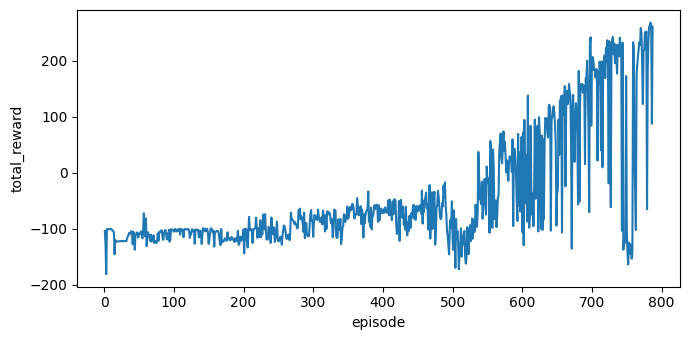

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["episode", "total_reward"]
df = pd.read_csv("input.csv", usecols=columns)
print("Contents in csv file:", df)
plt.xlabel('episode')
plt.ylabel('total_reward')
plt.plot(df.episode, df.total_reward)
plt.show()

Contents in csv file:      episode  avg_running
0          1  -104.302700
1          2  -104.521206
2          3  -105.290819
3          4  -105.246106
4          5  -105.209575
..       ...          ...
782      783    83.367717
783      784    85.211223
784      785    86.916102
785      786    86.916773
786      787    88.652271

[787 rows x 2 columns]


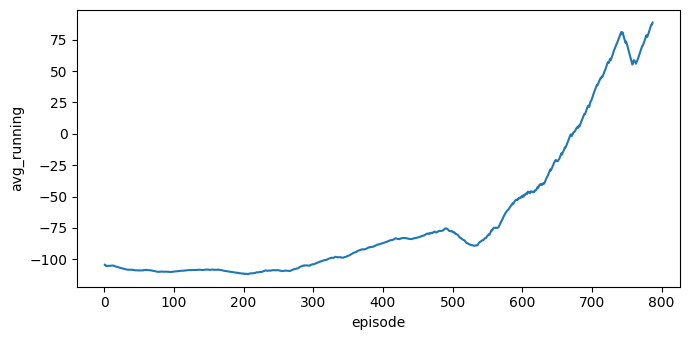

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["episode", "avg_running"]
df = pd.read_csv("input.csv", usecols=columns)
print("Contents in csv file:", df)
plt.xlabel('episode')
plt.ylabel('avg_running')
plt.plot(df.episode, df.avg_running)
plt.show()